#### About the Dataset

PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [30]:
import os
import kaggle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import numpy as np

import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE

In [31]:
# Setting the environment variable to the location of the kaggle.json file
os.environ['KAGGLE_CONFIG_DIR'] = "C:/Users/Renz/.kaggle"

# Verifying if the Kaggle API is configured properly
try:
    kaggle.api.authenticate()
    print('Kaggle API authentication successful.')
except Exception as e:
    print(f"Error: {e}")

Kaggle API authentication successful.


In [32]:
# Dataset link: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
dataset = 'robikscube/hourly-energy-consumption'
download_path = './data'

if not os.path.exists(download_path):
    os.makedirs(download_path)

kaggle.api.dataset_download_files(dataset, path=download_path, unzip=True)

print('Dataset downloaded and unzipped successfully.')

Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
Dataset downloaded and unzipped successfully.


In [33]:
df = pd.read_csv('./data/PJME_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

### Exploratory Data Analysis

In [34]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [35]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [37]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [38]:
color_pal = sns.color_palette()
color_pal

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [39]:
#df.plot(style='.', figsize=(15, 6), color=color_pal[0], title='PJME Energy Use in MW')
#plt.show()

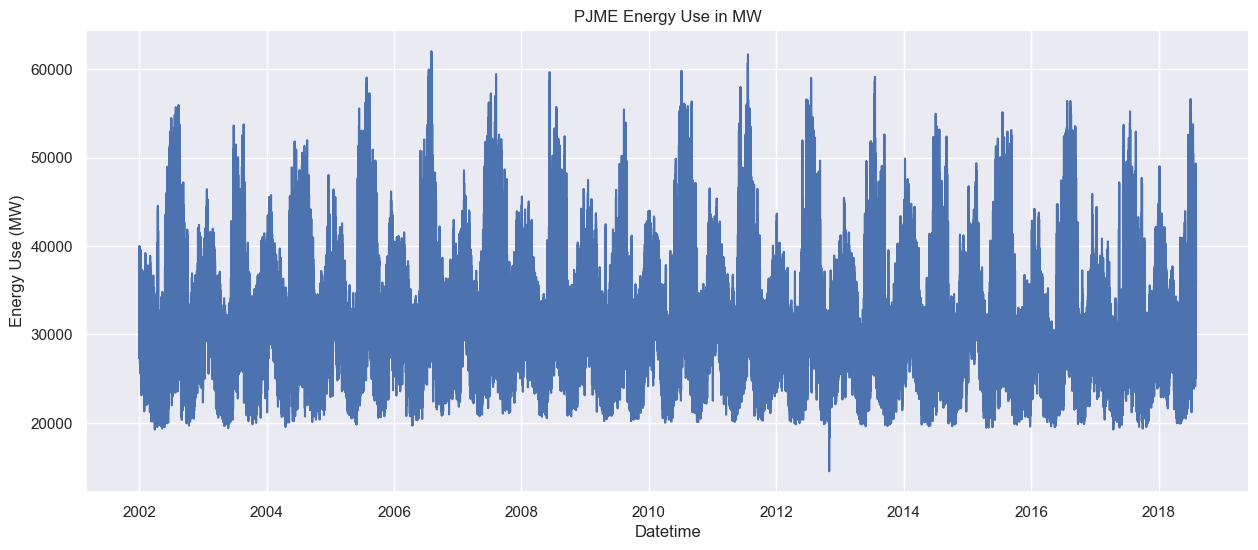

In [40]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='Datetime', y='PJME_MW', color=color_pal[0])
plt.title('PJME Energy Use in MW')
plt.xlabel('Datetime')
plt.ylabel('Energy Use (MW)')
plt.show()

### Train / Test Split

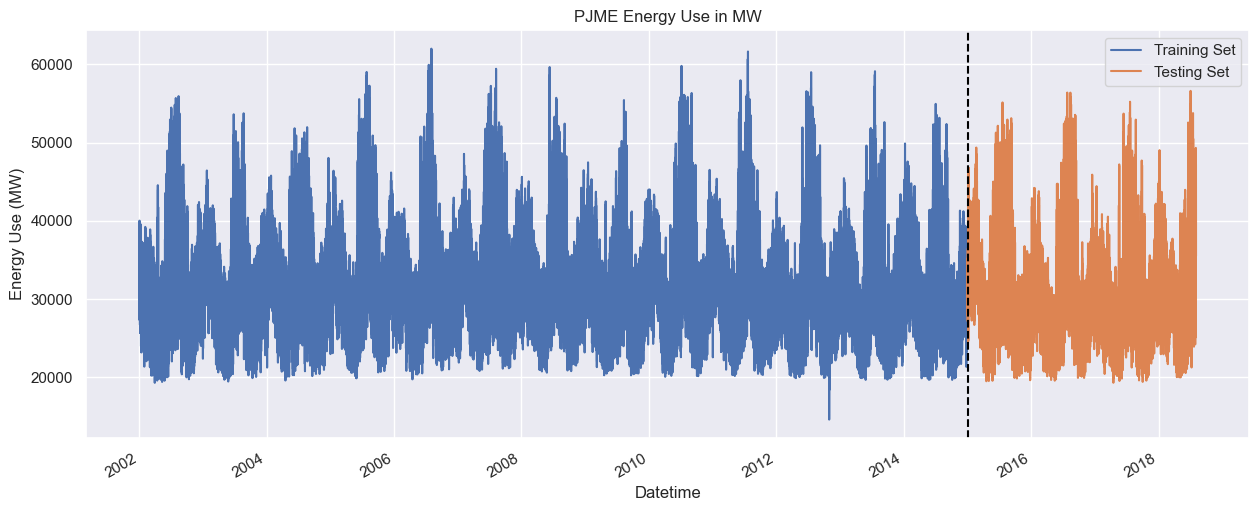

In [41]:
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 6))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Testing Set')

ax.axvline(pd.to_datetime('2015-01-01'), color='black', ls='--')
ax.legend(['Training Set', 'Testing Set'])
plt.title('PJME Energy Use in MW')
plt.ylabel('Energy Use (MW)')
plt.show()

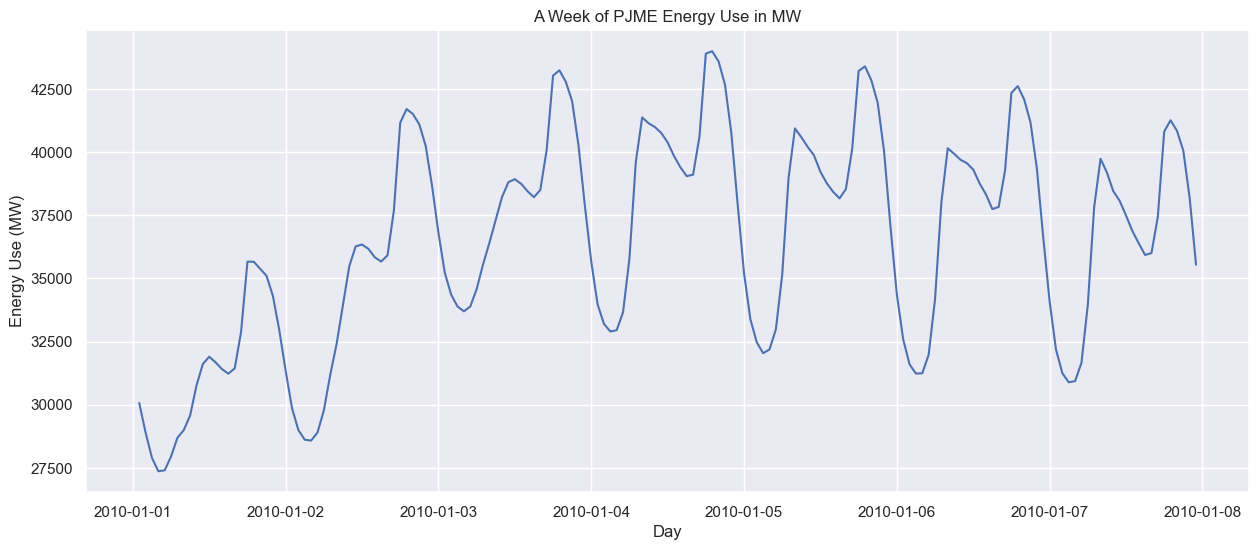

In [42]:
plt.figure(figsize=(15, 6))
weekly_data = df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')]
#weekly_data.plot(x='Datetime', y='PJME_MW')
sns.lineplot(data=weekly_data, x='Datetime', y='PJME_MW')
plt.title('A Week of PJME Energy Use in MW')
plt.xlabel('Day')
plt.ylabel('Energy Use (MW)')
plt.show()

### Feature Engineering

In [43]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.day_of_year
    return df

df = create_features(df)
df.head()

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


### Visualizing Feature-Target Relationship

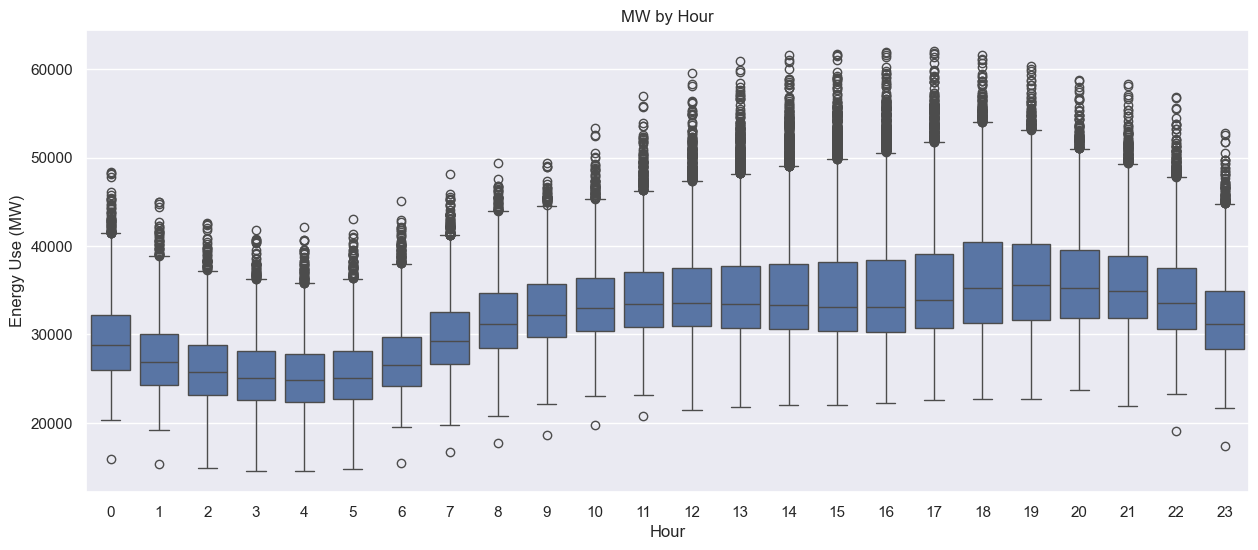

In [44]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='hour', y='PJME_MW')
plt.title('MW by Hour')
plt.xlabel('Hour')
plt.ylabel('Energy Use (MW)')
plt.show()

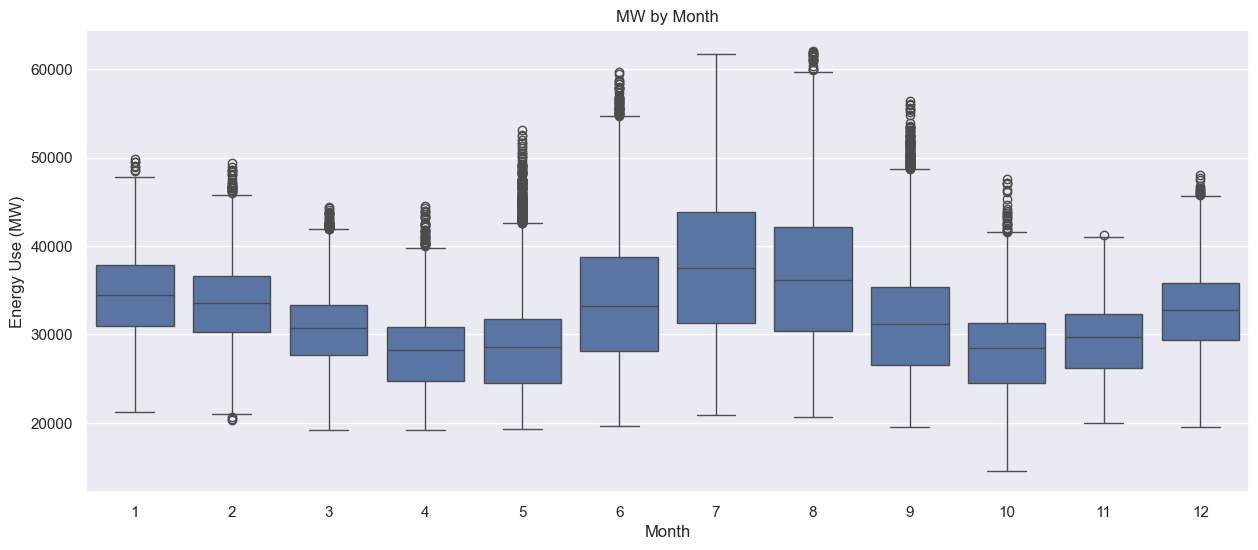

In [45]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='month', y='PJME_MW')
plt.title('MW by Month')
plt.xlabel('Month')
plt.ylabel('Energy Use (MW)')
plt.show()

### Modeling

In [46]:
train = create_features(train)
test = create_features(test)

In [47]:
df.columns

Index(['PJME_MW', 'hour', 'day_of_week', 'quarter', 'month', 'year',
       'day_of_year'],
      dtype='object')

In [48]:
features = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']
target = 'PJME_MW'

In [49]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [52]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

xgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[50]	validation_0-rmse:4762.32074	validation_1-rmse:5012.22041
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[150]	validation_0-rmse:3476.74522	validation_1-rmse:4012.03356
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[250]	validation_0-rmse:3096.08350	validation_1-rmse:3778.66977
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[350]	validation_0-rmse:2920.57462	validation_1-rmse:3742.00487
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance

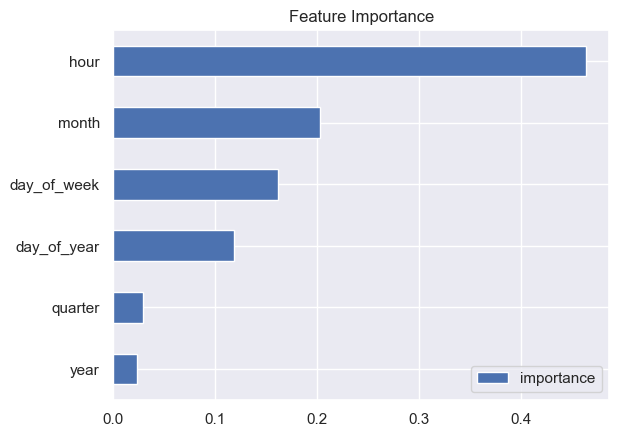

In [114]:
feature_importance = pd.DataFrame(xgb_reg.feature_importances_,
                                  index=xgb_reg.feature_names_in_,
                                  columns=['importance'])

feature_importance.sort_values('importance').plot(kind='barh')
plt.title('Feature Importance')
plt.show()

### Forecasting on the Test Set

In [70]:
test['prediction'] = xgb_reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)
df

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,41545.953125
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41135.625000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39968.492188


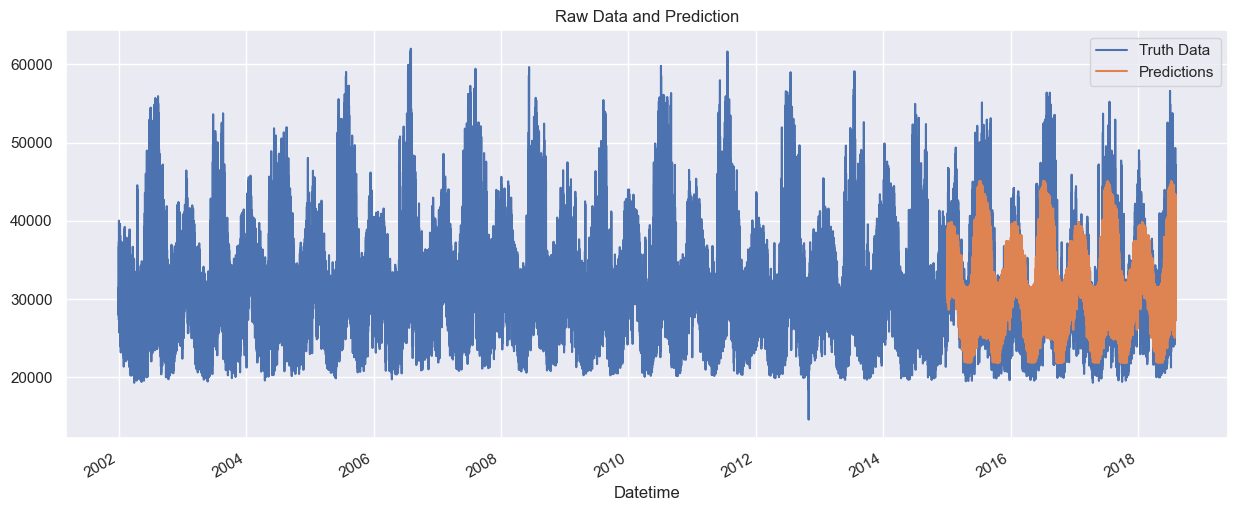

In [91]:
ax = df['PJME_MW'].plot(figsize=(15, 6))
df['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

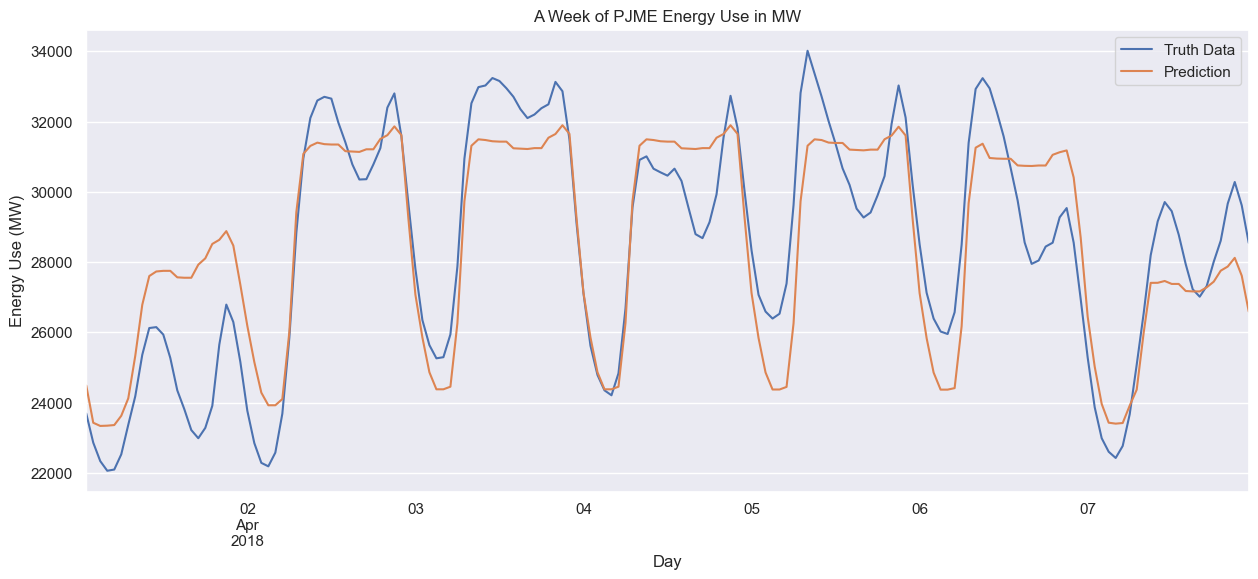

In [94]:
plt.figure(figsize=(15, 6))
plot1 = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['PJME_MW'].plot()
plot2 = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['prediction'].plot()
plt.title('A Week of PJME Energy Use in MW')
plt.xlabel('Day')
plt.ylabel('Energy Use (MW)')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

### Validation

In [106]:
xgb_score = np.sqrt(MSE(test['PJME_MW'], test['prediction']))
print(f'Test set RMSE score: {xgb_score:0.3f}')

Test set RMSE score: 3741.030


### Calculating Error

In [111]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [112]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64

### Next steps
- Perform a more robust cross validation
- Add more features such as weather forecast, holidays, etc.